In [110]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import utils # local file

plt.rcParams['font.size'] = 17.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
df = pd.read_csv('./2020_Problem_D_DATA/passingevents.csv')
df = df[df['TeamID'] == 'Huskies'] # We only study Huskies now
df

,MatchID,TeamID,OriginPlayerID,DestinationPlayerID,MatchPeriod,EventTime,EventSubType,EventOrigin_x,EventOrigin_y,EventDestination_x,EventDestination_y
0,1,Huskies,Huskies_D1,Huskies_F1,1H,46.323501,Head pass,34,97,59.0,95.0
1,1,Huskies,Huskies_M1,Huskies_F2,1H,51.022546,Simple pass,53,89,69.0,91.0
4,1,Huskies,Huskies_M2,Huskies_M3,1H,98.265191,Simple pass,42,55,36.0,54.0
8,1,Huskies,Huskies_D1,Huskies_F1,1H,130.656530,Head pass,34,91,52.0,97.0
11,1,Huskies,Huskies_D1,Huskies_G1,1H,161.221470,Simple pass,14,65,11.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...
23405,38,Huskies,Huskies_D4,Huskies_F6,2H,2676.466810,Simple pass,66,15,62.0,23.0
23406,38,Huskies,Huskies_F6,Huskies_M2,2H,2679.856529,Simple pass,62,23,66.0,39.0
23407,38,Huskies,Huskies_M2,Huskies_M1,2H,2682.271344,Simple pass,66,39,63.0,63.0
23408,38,Huskies,Huskies_M1,Huskies_F4,2H,2683.754085,Simple pass,63,63,73.0,55.0


In [112]:
# calculate average position of each player
uniq_player = np.unique(
    np.union1d(df['OriginPlayerID'], df['DestinationPlayerID']))
x_mean = [
    np.mean(
        list(df[df['OriginPlayerID'] == name]['EventOrigin_x']) +
        list(df[df['DestinationPlayerID'] == name]['EventDestination_x']))
    for name in uniq_player
]
y_mean = [
    np.mean(
        list(df[df['OriginPlayerID'] == name]['EventOrigin_y']) +
        list(df[df['DestinationPlayerID'] == name]['EventDestination_y']))
    for name in uniq_player
]

pos = {
    name: np.array([x_mean[i], y_mean[i]])
    for i, name in enumerate(uniq_player)
}

# Build Directional graph
G = nx.from_pandas_edgelist(df, source='OriginPlayerID', 
                            target='DestinationPlayerID', 
                            edge_attr=True, 
                            create_using=nx.DiGraph())

# Calculate degree centrality
deg_centrality = nx.algorithms.centrality.degree_centrality(G)
deg_centrality = np.array([deg_centrality[node] for node in list(G.nodes())])

# Calculate betweenness centrality
between_centrality = nx.algorithms.centrality.betweenness_centrality(G)
between_centrality = np.array([between_centrality[node] for node in list(G.nodes())])

# Calculate eigenvector centrality
eigen_centrality = nx.algorithms.centrality.eigenvector_centrality(G)
eigen_centrality = np.array([eigen_centrality[node] for node in list(G.nodes())])

# Calculate total (in + out) passes through a node
team_passes = utils.match_i_passing_table('./2020_Problem_D_DATA/passingevents.csv', 
                                          team_id='Huskies', match_i='all')
node_passes = np.array([np.sum(team_passes[node]) for node in list(G.nodes())])

# Calculate geometrical distance between nodes (as a weight)
geometrical_dist = {}
from scipy.spatial import distance
for edge in G.edges:
    geometrical_dist[edge] = distance.euclidean(pos[edge[0]], pos[edge[1]])


# Calculate passes from A to B (as a weight)
H = nx.from_pandas_edgelist(df[['OriginPlayerID', 'DestinationPlayerID']], 
                            source='OriginPlayerID', 
                            target='DestinationPlayerID', edge_attr=True, 
                            create_using=nx.MultiDiGraph()) ### Multi-Directional graph
unidirection_pass = {}
for edge in H.edges:
    unidirection_pass[(edge[0], edge[1])] = H.number_of_edges(edge[0], edge[1])

# Weight 
weight_dict = {}
for edge in G.edges:
    if geometrical_dist[edge] == 0:
        dist = 0
    else:
        dist = 100 / geometrical_dist[edge]
        dist /= 10
    passes = unidirection_pass[edge] / 5
    weight = dist + passes
    weight_dict[edge] = weight

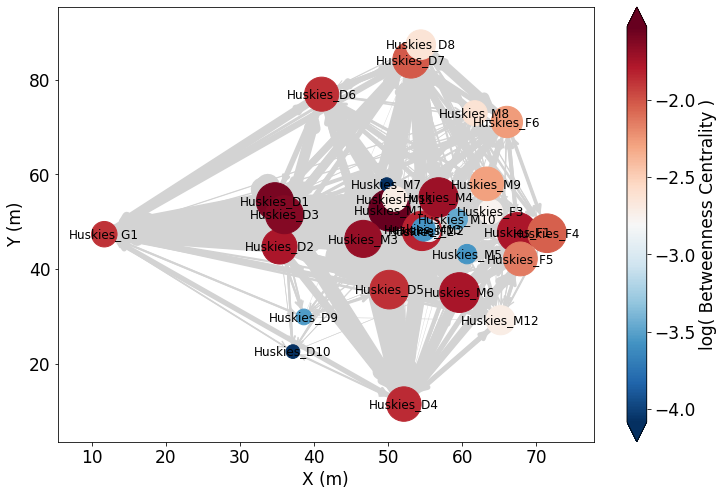

In [113]:
#%matplotlib qt
# Plot the network
fig, ax = plt.subplots(figsize=(12, 8))

node_size = np.exp(eigen_centrality / np.sort(eigen_centrality)[1])
node_size = node_size / np.nanmean(node_size) * 1000

node_color = np.log10(between_centrality)

edge_width = np.array(list(weight_dict.values()))

nx.draw_networkx(G, pos, ax=ax, 
                 node_size=node_size, 
                 node_color=node_color, 
                 edgelist=list(unidirection_pass.keys()), 
                 width=edge_width,
                 edge_color='lightgray', 
                 cmap='RdBu_r', 
                 vmin=node_color[~np.isinf(node_color)][-1], 
                 vmax=max(node_color), arrowsize=15, arrowstyle='->')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=node_color[~np.isinf(node_color)][-1], 
                                                             vmax=max(node_color)))
cbar = plt.colorbar(sm, ax=ax, extend='both')
cbar.set_label('log( Betweenness Centrality )')

#plt.savefig('./all_players_huskies.png', bbox_inches='tight', dpi=150)
#plt.show()

### 清理之后的布阵图
D1, D2, D3

D7, D8

D9, D10

F1, F4, F5

F2, M13, M2

M8, F6

In [95]:
df_reduce = df.copy()

In [96]:
for ind, row in df_reduce.iterrows():
    for prefix in ['OriginPlayerID', 'DestinationPlayerID']:
        if row[prefix].strip('Huskies_') in ['D1', 'D2', 'D3']:
            df_reduce.loc[ind, prefix] = 'Huskies_D1'
        if row[prefix].strip('Huskies_') in ['D7', 'D8']:
            df_reduce.loc[ind, prefix] = 'Huskies_D7'
        if row[prefix].strip('Huskies_') in ['D9', 'D10']:
            df_reduce.loc[ind, prefix] = 'Huskies_D9'
        if row[prefix].strip('Huskies_') in ['F1', 'F4', 'F5']:
            df_reduce.loc[ind, prefix] = 'Huskies_F1'
        if row[prefix].strip('Huskies_') in ['F2', 'M13', 'M2']:
            df_reduce.loc[ind, prefix] = 'Huskies_M2'
        if row[prefix].strip('Huskies_') in ['M8', 'F6']:
            df_reduce.loc[ind, prefix] = 'Huskies_F6'

In [97]:
from network import build_network, plot_network

In [104]:
G, pos, centrality_dict, geometrical_dist, unidirection_pass, weight_dict = build_network(df_reduce, 
                                                                                          team='Huskies', 
                                                                                          matchid='all')

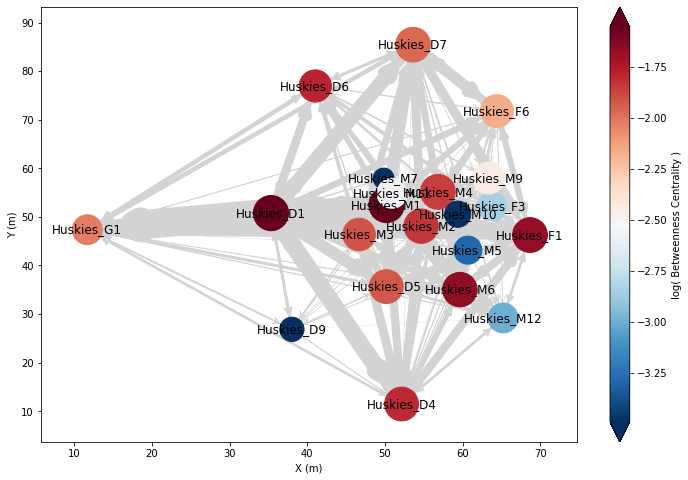

In [105]:
#%matplotlib qt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
eigen_centrality = centrality_dict['eigen_centrality']
between_centrality = centrality_dict['between_centrality']
    
node_size = np.exp(eigen_centrality / np.percentile(eigen_centrality, 15))
node_size = node_size / np.nanmean(node_size) * 1000

node_color = np.log10(between_centrality)

edge_width = np.array(list(weight_dict.values())) / 2

nx.draw_networkx(G, pos, ax=ax, 
                 node_size=node_size, 
                 node_color=node_color, 
                 edgelist=list(unidirection_pass.keys()), 
                 width=edge_width,
                 edge_color='lightgray', 
                 cmap='RdBu_r', 
                 vmin=node_color[~np.isinf(node_color)][-1], 
                 vmax=max(node_color), arrowsize=15, arrowstyle='->')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=node_color[~np.isinf(node_color)][-1], 
                                                             vmax=max(node_color)))
cbar = plt.colorbar(sm, ax=ax, extend='both')
cbar.set_label('log( Betweenness Centrality )')

plt.show()

## Calculate Motifs

In [141]:
from utils import mcounter

In [142]:
## We define each S* motif as a directed graph in networkx
## up=1, down=3, right=2
motifs = {
    'S1': nx.DiGraph([(2,1),(2,3)]),
    'S2': nx.DiGraph([(3,2),(2,1)]),
    'S3': nx.DiGraph([(3,2),(2,3),(2,1)]),
    'S4': nx.DiGraph([(3,1),(2,1)]),
    'S5': nx.DiGraph([(3,1),(2,1),(2,3)]),
    'S6': nx.DiGraph([(3,1),(2,1),(2,3),(3,2)]),
    'S7': nx.DiGraph([(3,2),(2,3),(1,2)]),
    'S8': nx.DiGraph([(3,2),(2,3),(2,1),(1,2)]),
    'S9': nx.DiGraph([(1,2),(2,3),(3,1)]),
    'S10': nx.DiGraph([(1,2),(2,3),(3,1),(2,1)]),
    'S11': nx.DiGraph([(1,2),(2,1),(3,2),(3,1)]),
    'S12': nx.DiGraph([(1,2),(2,1),(3,2),(2,3),(3,1)]),
    'S13': nx.DiGraph([(1,2),(2,1),(2,3),(3,2),(3,1),(1,3)])
    }

In [143]:
mcounter(G, motifs, weight_dict)

({'S1': 10,
  'S2': 31,
  'S3': 119,
  'S4': 12,
  'S5': 8,
  'S6': 29,
  'S7': 178,
  'S8': 795,
  'S9': 4,
  'S10': 37,
  'S11': 40,
  'S12': 603,
  'S13': 1542},
 {'S1': 20.667617971150335,
  'S2': 56.07327349692114,
  'S3': 578.3936839518581,
  'S4': 16.737507579580367,
  'S5': 44.20353289120351,
  'S6': 379.7123383371463,
  'S7': 1132.2360877601911,
  'S8': 8639.073249934181,
  'S9': 25.52982367360517,
  'S10': 296.41970945558194,
  'S11': 395.38915929047624,
  'S12': 10171.570662239223,
  'S13': 46014.11780560427})